In [257]:
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from io import StringIO
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold

In [157]:
### Function of creating confusion matrix figure
def print_confusion_matix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    import seaborn as sns
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="g")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return heatmap

In [231]:
### Function of PQN normalisation 
def pqn_andNormalized(data):
    
    from sklearn.preprocessing import Normalizer
    ref_spec = data.median(axis=0)
    
        
    FoldChange = data / ref_spec[:,None].T
    
    na = FoldChange == 0
    FoldChange[na] = np.nan
    
    median_FC = np.nanmedian(FoldChange, axis=1)
    
    median_FC[np.isinf(median_FC)] = 1
    median_FC[np.isnan(median_FC)] = 1
    median_FC[median_FC == 0] = 1
    
    data_norm = data / median_FC[:,None]
    
    
    tmpData = data_norm[data_norm != 0]
    logOS = np.nanmedian(tmpData)
    data_norm = np.log(data_norm+logOS)
    
    scaler = Normalizer().fit(data_norm)
    data_norm = scaler.transform(data_norm)

    data_norm = DataFrame(data_norm)
    data_norm.columns = data.columns
    data_norm = data_norm * 1000
        
    return data_norm

In [232]:
### Function of PCA analysis
def pcaAnalysis(data):
    import pandas as pd
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    pca_scores = pca.fit(data).transform(data)

    pca_variance = pca.explained_variance_ratio_
    pca_loading = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'])
    
    return pca_scores, pca_variance, pca_loading


In [233]:
## Function of constructing PCA plot
def PCAplot(pca_scores, pca_variance, pca_loading, mz, group):

    target_names,y = np.unique(group,return_inverse = True)

    fig,axs = plt.subplots(ncols=3,constrained_layout=True,figsize=(15,5))


    colors = ['red', 'navy','green','orange']
    lw = 1

    for color, i, target_name in zip(colors, [0,1,2,3], target_names):
        axs[0].scatter(pca_scores[y == i, 0], pca_scores[y == i, 1], color=color, alpha=.5, lw=lw,label=target_name)
    
    axs[0].legend(loc='best', shadow=False, scatterpoints=1)
    axs[0].set_title('PC scores plot')
    axs[0].set_xlabel('PC1 %0.2f %%' % (pca_variance[0] * 100))
    axs[0].set_ylabel('PC2 %0.2f %%' % (pca_variance[1] * 100))

    axs[1].scatter(pca_loading['PC1'],pca_loading['PC2'])
    axs[1].set_title('PC loadings plot')
    axs[1].set_xlabel('PC1 %0.2f %%' % (pca_variance[0] * 100))
    axs[1].set_ylabel('PC2 %0.2f %%' % (pca_variance[1] * 100))

    axs[2].plot(mz,pca_loading['PC1'], 'red')
    axs[2].plot(mz,pca_loading['PC2'], 'royalblue')
    axs[2].set_title('PC loadings plot')
    axs[2].set_xlabel('m/z')
    axs[2].set_ylabel('PC loadings')
    

In [234]:
### Function of evaluation of eight machine learning algorithms for 10 iterations
def ML_Evaluation(data, group1):
    
    ## To evaluate machine learning models with raw data (KFold)
    from sklearn.model_selection import RepeatedKFold
    from sklearn.ensemble import RandomForestClassifier
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(('XGB', XGBClassifier()))
   
    models.append(('RF', RandomForestClassifier()))
    modelList = ['LR','LDA','KNN','CART','NB','SVM','RF','XGB']
    results = []
    names = []
    scoring = 'accuracy'

    # Store results in a pandas dataframe
    numIterations = 10
    allResults = pd.DataFrame(index=range(0,numIterations), columns=modelList)
    #skf = StratifiedKFold(n_splits=numIterations, random_state=42, shuffle=True)
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats = 2, random_state=42)
    for name, model in models:
    
        for n in range(0,numIterations):
        
            # Cross validated model generation
        
            cv_results = cross_val_score(model, data, group1, cv=rkf, scoring=scoring)
        
            # Mean classification for iteration[n]
            allResults[name] = cv_results.tolist()
        
            # Status message
            msg = "Method %s Iteration [%d]\r" % (name, n)
            print(msg,end="")
            
    return allResults

In [235]:
### Importing the iKnife data
data = pd.read_csv("/Users/teeraponsahwangarrom/Desktop/NewFullGlobalData_iknifeTCDvsN.csv")
keep = data['Tissue_type'] != "Other"
data = data[keep]
dataVars = data.iloc[:,42:]
dataVars = dataVars.drop(['Tissue_type'], axis=1)
mz_tmp = dataVars.columns.values
mz = mz_tmp.astype(np.float)
dataVars.shape

(2735, 931)

In [236]:
dataVars.drop_duplicates(inplace=True)
dataVars.shape

(1755, 931)

In [237]:
idx = dataVars.index

In [238]:
data = data.loc[idx]
data.reset_index(inplace=True)
dataVars.reset_index(inplace=True)
dataVars = dataVars.drop(['index'],axis=1)

In [239]:
dataVars_norm = pqn_andNormalized(dataVars)

/Users/teeraponsahwangarrom/opt/anaconda3/envs/bioinfo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [240]:
pca_scores, pca_variance, pca_loading = pcaAnalysis(dataVars_norm)

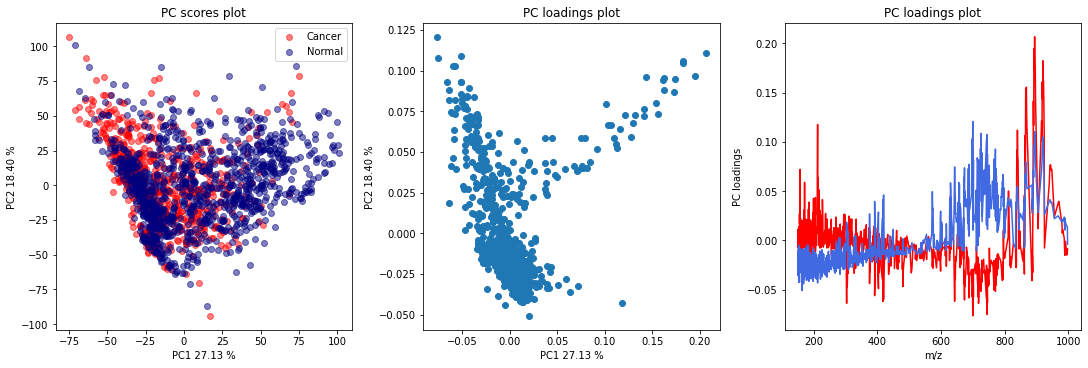

In [241]:
PCAplot(pca_scores, pca_variance, pca_loading, mz, data['Tissue_type'])
plt.savefig('/Users/teeraponsahwangarrom/PCAplot_Project2.png', dpi=300)

In [230]:
dataVars_norm[mf].to_csv('/Users/teeraponsahwangarrom/Desktop/DataVolcanoPlot2.csv')

In [198]:
dataVars_norm

,150.9820,151.0330,151.0400,151.0490,151.0870,151.1380,151.9830,152.0380,152.0440,152.0850,...,979.7350,980.7680,981.7480,986.7620,988.5320,988.7730,990.7870,994.6280,996.6510,997.2500
0,0.001393,0.000361,0.000717,0.002626,0.000619,0.000304,0.000321,0.000940,0.001347,0.001869,...,0.007677,0.004983,0.008274,0.004295,0.001221,0.004071,0.005046,0.002678,0.002953,0.000591
1,0.000532,0.000795,0.001241,0.001832,0.001964,0.000315,0.000217,0.001648,0.002837,0.001399,...,0.011729,0.018264,0.015558,0.031057,0.004446,0.031057,0.020681,0.005444,0.007625,0.000729
2,0.002490,0.002621,0.003313,0.004270,0.007019,0.000183,0.002076,0.005070,0.007024,0.002433,...,0.002980,0.002711,0.002564,0.002285,0.000979,0.002297,0.002407,0.001759,0.002447,0.000313
3,0.000520,0.000844,0.001809,0.002314,0.002163,0.000076,0.000333,0.001072,0.001465,0.001318,...,0.001722,0.002070,0.001912,0.002959,0.001513,0.002787,0.002587,0.001432,0.001003,0.000563
4,0.002027,0.001801,0.002627,0.004111,0.005019,0.000267,0.001739,0.002257,0.003409,0.002795,...,0.002617,0.003486,0.002705,0.004809,0.002657,0.004181,0.003634,0.002393,0.002619,0.001018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010352,0.000000,0.000000
1752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.049843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.082836,0.000000,0.000000,0.000000,0.000000,0.000000


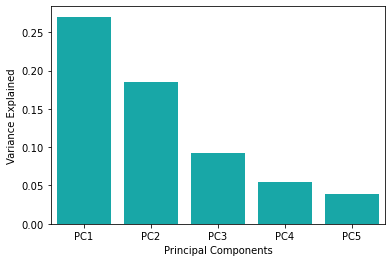

In [394]:
import seaborn as sns
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca.fit(dataVars_norm).transform(dataVars_norm)
pca.explained_variance_ratio_

pcaData = pd.DataFrame({'Variance Explained':pca.explained_variance_ratio_, 'Principal Components':['PC1','PC2','PC3','PC4','PC5']})
sns.barplot(x='Principal Components', y="Variance Explained", data=pcaData, color="c")
#pc_df = pd.DataFrame(data = pc, columns =['PC1','PC2','PC3','PC4','PC5'])

In [390]:
pca.explained_variance_ratio_

array([0.27028165, 0.18569495, 0.09274724, 0.05411577, 0.03923206])

In [145]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca.fit(dataVars_norm).transform(dataVars_norm)
loading_scores = pd.Series(pca.components_[0], index=mz_tmp)

sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_100_mz = sorted_loading_scores[0:100].index.values
#print(loading_scores[top_100_mz])
#top_100_mz
loading_scores[top_100_mz]

893.7370    0.206629
891.7220    0.194327
919.7520    0.182241
894.7400    0.181899
895.7430    0.173383
              ...   
721.4820   -0.041981
227.2010    0.041795
728.5590   -0.041731
749.5170   -0.040968
885.5550   -0.040909
Length: 100, dtype: float64

In [147]:
top_100_mz

array(['893.7370', '891.7220', '919.7520', '894.7400', '895.7430',
       '892.7260', '920.7570', '921.7620', '917.7370', '867.7180',
       '865.7060', '918.7410', '889.7050', '896.7460', '922.7660',
       '866.7100', '868.7230', '915.7210', '212.0750', '890.7070',
       '869.7250', '839.6890', '923.7720', '863.6900', '863.6610',
       '916.7220', '837.6740', '840.6930', '841.6970', '864.6920',
       '699.4980', '943.7460', '941.7310', '744.5550', '864.6580',
       '157.1220', '947.7830', '945.7640', '838.6790', '700.5040',
       '717.5100', '213.0780', '303.2340', '745.5570', '417.2410',
       '642.4880', '673.4820', '419.2570', '742.5400', '171.1380',
       '687.5450', '718.5370', '701.5140', '939.7180', '716.5260',
       '697.4820', '391.2250', '687.4990', '725.5130', '770.5710',
       '723.4990', '743.5370', '217.1110', '768.5530', '766.5400',
       '811.6600', '403.2620', '744.6110', '698.4860', '715.4980',
       '715.5230', '305.2560', '674.4850', '888.6830', '746.56

In [146]:
loading_scores[top_100_mz].to_csv('/Users/teeraponsahwangarrom/Desktop/Top100_loadingPCA.csv')

In [169]:
ML_results_rskf = ML_Evaluation(dataVars_norm, data['Tissue_type'])

In [170]:
ML_results_rskf

,LR,LDA,KNN,CART,NB,SVM,RF,XGB
0,0.829060,0.766382,0.803419,0.735043,0.663818,0.840456,0.826211,0.851852
1,0.874644,0.794872,0.794872,0.729345,0.615385,0.877493,0.820513,0.863248
2,0.886040,0.797721,0.806268,0.754986,0.692308,0.880342,0.846154,0.871795
3,0.866097,0.800570,0.849003,0.754986,0.649573,0.874644,0.846154,0.868946
4,0.863248,0.780627,0.780627,0.712251,0.692308,0.849003,0.811966,0.849003
5,0.897436,0.774929,0.834758,0.732194,0.686610,0.880342,0.866097,0.866097
6,0.857550,0.772080,0.800570,0.729345,0.592593,0.843305,0.797721,0.846154
7,0.897436,0.800570,0.826211,0.794872,0.672365,0.868946,0.834758,0.840456
8,0.837607,0.774929,0.780627,0.709402,0.646724,0.837607,0.800570,0.814815
9,0.846154,0.780627,0.820513,0.754986,0.658120,0.857550,0.837607,0.868946


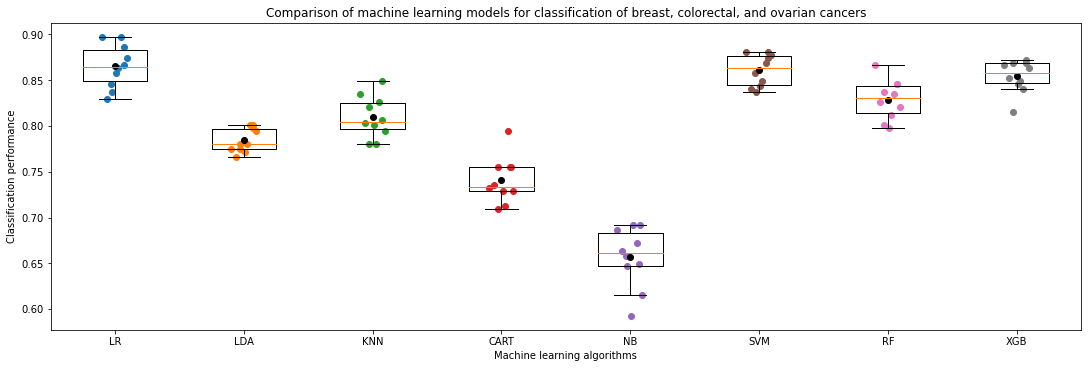

In [173]:
# Draw axes
fig,ax = plt.subplots(ncols=1,constrained_layout=True,figsize=(15,5))
modelList = ['LR','LDA','KNN','CART','NB','SVM','RF','XGB']

# Making Boxplots
ax.boxplot(ML_results_rskf.T,sym='',labels=modelList)


# Adding the scatter points with jitter
jitter = (np.random.rand(10,1) - 0.5) / 4
for n in range(0,8):
    ax.scatter(jitter+n+1,ML_results_rskf[modelList[n]])
    ax.scatter(n+1,ML_results_rskf[modelList[n]].mean(), color ='black')
    
    
# Titles, label of x-axis and y-axis
ax.set_title('Comparison of machine learning models for classification of breast, colorectal, and ovarian cancers')
ax.set_xlabel('Machine learning algorithms')
ax.set_ylabel('Classification performance')
plt.savefig('/Users/teeraponsahwangarrom/Boxplot_EvaluationML_Project2.png', dpi=300)

In [500]:
#### Calculation of accuracy, sensitivity and specificity in order to construct a learning curve 
import time
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))
#models.append(('XGB', XGBClassifier(max_depth =4, n_estimators=150)))

#models.append(('RF', RandomForestClassifier(max_features=6, n_estimators=1000)))
modelList = ['LR']
results = []
names = []
scoring = 'accuracy'

# Store results in a pandas dataframe
numIterations = 10
#idx = 70
allAccuracy = pd.DataFrame(index=range(0,numIterations), columns=modelList)
allSensitivity = pd.DataFrame(index=range(0,numIterations), columns=modelList)
allSpecificity = pd.DataFrame(index=range(0,numIterations), columns=modelList)
allTime = pd.DataFrame(index=range(0,numIterations), columns=modelList)
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats = 2, random_state=42)

for n,(train_idx, test_idx) in enumerate(rkf.split(dataVars_norm, data['Tissue_type']),0):
    
    for name, model in models:
        
        
    
        X_train = dataVars_norm.iloc[train_idx]
        y_train = data['Tissue_type'].iloc[train_idx]
        X_test = dataVars_norm.iloc[test_idx]
        y_test = data['Tissue_type'].iloc[test_idx]
        
        #feature_RFE = fc_rkf.loc[:,['molecular_features']]
        
        #mf = feature_RFE[:90].values
        #mf = mf.flatten()
        X_train = X_train[mf]
        X_test = X_test[mf]
        
        # Cross validated model generation
        start_time = time.time()
        model.fit(X_train[:1404], y_train[:1404])
        end_time = time.time()
        y_pred = model.predict(X_test)
        
        
        cm = confusion_matrix(y_test, y_pred)
        total = sum(sum(cm))
        print('Round: ', n, name)
        Accuracy = (cm[0,0]+cm[1,1])/total
        print('Accuracy: ', Accuracy*100)
        
        Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
        print('Sensitivity: ', Sensitivity*100)
        Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
        print('Specificity: ', Specificity*100)
        
        
        allAccuracy.iloc[n][name] = Accuracy*100
        allSensitivity.iloc[n][name] = Sensitivity*100
        allSpecificity.iloc[n][name] = Specificity*100
        allTime.iloc[n][name] = end_time - start_time
        

Round:  0 LR
Accuracy:  87.46438746438746
Sensitivity:  85.0
Specificity:  89.0995260663507
Round:  1 LR
Accuracy:  90.02849002849003
Sensitivity:  85.0
Specificity:  93.36492890995261
Round:  2 LR
Accuracy:  90.5982905982906
Sensitivity:  88.48920863309353
Specificity:  91.98113207547169
Round:  3 LR
Accuracy:  93.16239316239316
Sensitivity:  89.92805755395683
Specificity:  95.28301886792453
Round:  4 LR
Accuracy:  88.03418803418803
Sensitivity:  82.01438848920863
Specificity:  91.98113207547169
Round:  5 LR
Accuracy:  91.73789173789174
Sensitivity:  90.0
Specificity:  92.89099526066352
Round:  6 LR
Accuracy:  90.02849002849003
Sensitivity:  85.0
Specificity:  93.36492890995261
Round:  7 LR
Accuracy:  89.17378917378917
Sensitivity:  82.73381294964028
Specificity:  93.39622641509435
Round:  8 LR
Accuracy:  88.03418803418803
Sensitivity:  89.20863309352518
Specificity:  87.26415094339622
Round:  9 LR
Accuracy:  90.02849002849003
Sensitivity:  83.45323741007195
Specificity:  94.339622641

In [501]:
allAccuracy.mean()

LR    89.82906
dtype: float64

In [502]:
allAccuracy.std()

LR    1.761627
dtype: float64

In [503]:
allSensitivity.mean()

LR    86.082734
dtype: float64

In [504]:
allSpecificity.mean()

LR    92.296566
dtype: float64

In [505]:
allTime.mean()

LR    0.050134
dtype: float64

In [307]:
## Function of creating learning curves (Not be used for the project 2)
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 7)):
    from sklearn.model_selection import learning_curve
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


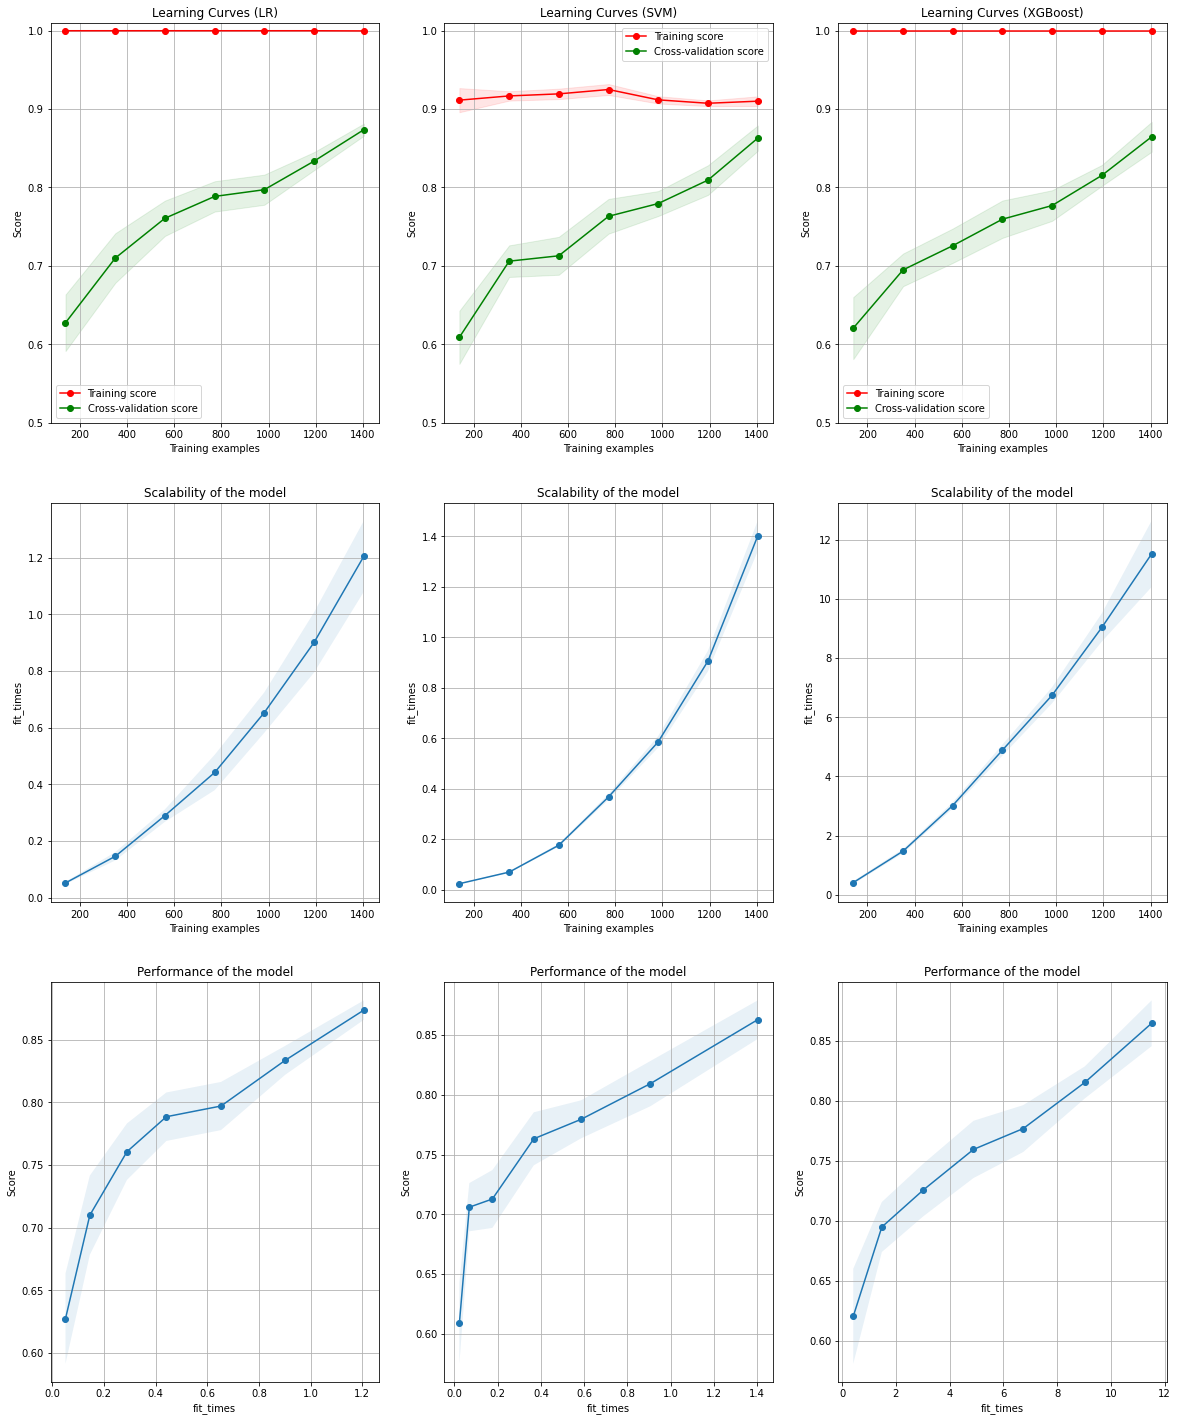

In [311]:
## Top 3 machine learning models from the results of the evaluation 
fig, axes = plt.subplots(3, 3, figsize=(20, 25))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves (LR)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

estimator = LogisticRegression(solver='liblinear')
plot_learning_curve(estimator, title, dataVars_norm, data['Tissue_type'], axes=axes[:, 0], ylim=(0.5, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
estimator = SVC()
plot_learning_curve(estimator, title, dataVars_norm, data['Tissue_type'], axes=axes[:, 1], ylim=(0.5, 1.01),cv=cv, n_jobs=4)

title = "Learning Curves (XGBoost)"
estimator = XGBClassifier(max_depth =4, n_estimators=150)
plot_learning_curve(estimator, title, dataVars_norm, data['Tissue_type'], axes=axes[:, 2], ylim=(0.5, 1.01),cv=cv, n_jobs=4)

plt.show()

In [258]:
## Function of constructing cross-validation behaviours
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    from matplotlib.patches import Patch
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm
    

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 1700])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [18]:
data['Tissue'] == 'Breast'

0        True
1        True
2        True
3        True
4        True
        ...  
1750    False
1751    False
1752    False
1753    False
1754    False
Name: Tissue, Length: 1755, dtype: bool

In [22]:
from collections import Counter
#idx_breast = data['Tissue'] == 'Gynae'
Counter(data['Tissue'])

Counter({'Breast': 1367, 'Colorectal': 304, 'Gynae': 84})

In [243]:
### Binarized the label of classes
z = data['Tissue']
z = label_binarize(z, classes=["Breast","Colorectal", "Gynae"])
y = data['Tissue_type']
y = label_binarize(y, classes=["Cancer","Normal"])

/Users/teeraponsahwangarrom/opt/anaconda3/envs/bioinfo/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


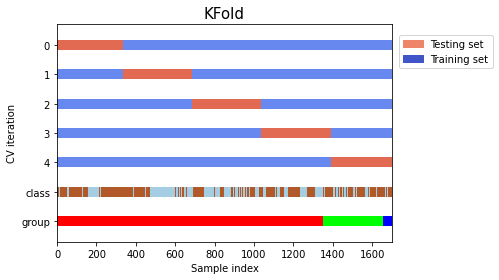

In [259]:
## A figure of K-Fold cross-validation behaviours
fig, ax = plt.subplots()
cv = KFold(n_splits = 5, random_state=42)
plot_cv_indices(cv, dataVars_norm, y, z, ax, 5)

plt.savefig('/Users/teeraponsahwangarrom/KFoldPic.png', dpi=300)

In [418]:
## An example of repeated stratified K-Fold splitting data into training (80%) and testing (20%) dataset
from sklearn.model_selection import KFold
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
for train_idx, test_idx in kf.split(dataVars_norm, data['Tissue_type']):
    train_X, test_X = dataVars_norm.iloc[train_idx], dataVars_norm.iloc[test_idx]
    train_y, test_y = data['Tissue_type'].iloc[train_idx], data['Tissue_type'].iloc[test_idx]
    
    train_cancer, train_normal = len(train_y[train_y=="Cancer"]), len(train_y[train_y=="Normal"])
    test_cancer, test_normal = len(test_y[test_y=="Cancer"]), len(test_y[test_y=="Normal"])
    print('Train: Cancer = %d, Normal = %d' % (train_cancer, train_normal))
    
    print('Test: Cancer = %d, Normal = %d' % (test_cancer, test_normal))
    

Train: Cancer = 557, Normal = 847
Test: Cancer = 140, Normal = 211
Train: Cancer = 557, Normal = 847
Test: Cancer = 140, Normal = 211
Train: Cancer = 558, Normal = 846
Test: Cancer = 139, Normal = 212
Train: Cancer = 558, Normal = 846
Test: Cancer = 139, Normal = 212
Train: Cancer = 558, Normal = 846
Test: Cancer = 139, Normal = 212
Train: Cancer = 557, Normal = 847
Test: Cancer = 140, Normal = 211
Train: Cancer = 557, Normal = 847
Test: Cancer = 140, Normal = 211
Train: Cancer = 558, Normal = 846
Test: Cancer = 139, Normal = 212
Train: Cancer = 558, Normal = 846
Test: Cancer = 139, Normal = 212
Train: Cancer = 558, Normal = 846
Test: Cancer = 139, Normal = 212


In [254]:
## An example of K-Fold splitting data into training (80%) and testing (20%) dataset
from sklearn.model_selection import KFold
skf = KFold(n_splits=10,random_state=42)
for train_idx, test_idx in skf.split(dataVars_norm, data['Tissue_type']):
    train_X, test_X = dataVars_norm.iloc[train_idx], dataVars_norm.iloc[test_idx]
    train_y, test_y = data['Tissue'].iloc[train_idx], data['Tissue'].iloc[test_idx]
    
    train_Breast, train_Colorectal, train_Gynae = len(train_y[train_y=="Breast"]), len(train_y[train_y=="Colorectal"]), len(train_y[train_y=="Gynae"])
    test_Breast, test_Colorectal, test_Gynae = len(test_y[test_y=="Breast"]), len(test_y[test_y=="Colorectal"]), len(test_y[test_y=="Gynae"])
    print('Train: Breast = %d, Colorectal = %d, Gynae = %d' % (train_Breast, train_Colorectal, train_Gynae))
    
    print('Test: Breast = %d, Colorectal = %d, Gynae = %d' % (test_Breast, test_Colorectal, test_Gynae))
    

Train: Breast = 1191, Colorectal = 304, Gynae = 84
Test: Breast = 176, Colorectal = 0, Gynae = 0
Train: Breast = 1191, Colorectal = 304, Gynae = 84
Test: Breast = 176, Colorectal = 0, Gynae = 0
Train: Breast = 1191, Colorectal = 304, Gynae = 84
Test: Breast = 176, Colorectal = 0, Gynae = 0
Train: Breast = 1191, Colorectal = 304, Gynae = 84
Test: Breast = 176, Colorectal = 0, Gynae = 0
Train: Breast = 1191, Colorectal = 304, Gynae = 84
Test: Breast = 176, Colorectal = 0, Gynae = 0
Train: Breast = 1192, Colorectal = 304, Gynae = 84
Test: Breast = 175, Colorectal = 0, Gynae = 0
Train: Breast = 1192, Colorectal = 304, Gynae = 84
Test: Breast = 175, Colorectal = 0, Gynae = 0
Train: Breast = 1230, Colorectal = 266, Gynae = 84
Test: Breast = 137, Colorectal = 38, Gynae = 0
Train: Breast = 1367, Colorectal = 129, Gynae = 84
Test: Breast = 0, Colorectal = 175, Gynae = 0
Train: Breast = 1367, Colorectal = 213, Gynae = 0
Test: Breast = 0, Colorectal = 91, Gynae = 84


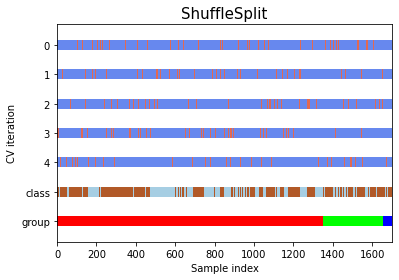

In [248]:
## A figure of shuffle split cross-validation behaviours
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=5)
plot_cv_indices(cv, dataVars_norm, y, z, ax, 5)
plt.savefig('/Users/teeraponsahwangarrom/SSPic.png', dpi=300)

In [174]:
## An example of shuffle split for splitting data into training (80%) and testing (20%) dataset
from sklearn.model_selection import KFold
kf = ShuffleSplit(n_splits=5, random_state=42)
for train_idx, test_idx in kf.split(dataVars_norm, data['Tissue_type']):
    train_X, test_X = dataVars_norm.iloc[train_idx], dataVars_norm.iloc[test_idx]
    train_y, test_y = data['Tissue'].iloc[train_idx], data['Tissue'].iloc[test_idx]
    
    train_Breast, train_Colorectal, train_Gynae = len(train_y[train_y=="Breast"]), len(train_y[train_y=="Colorectal"]), len(train_y[train_y=="Gynae"])
    test_Breast, test_Colorectal, test_Gynae = len(test_y[test_y=="Breast"]), len(test_y[test_y=="Colorectal"]), len(test_y[test_y=="Gynae"])
    print('Train: Breast = %d, Colorectal = %d, Gynae = %d' % (train_Breast, train_Colorectal, train_Gynae))
    
    print('Test: Breast = %d, Colorectal = %d, Gynae = %d' % (test_Breast, test_Colorectal, test_Gynae))
    

Train: Breast = 1225, Colorectal = 286, Gynae = 68
Test: Breast = 142, Colorectal = 18, Gynae = 16
Train: Breast = 1228, Colorectal = 274, Gynae = 77
Test: Breast = 139, Colorectal = 30, Gynae = 7
Train: Breast = 1235, Colorectal = 270, Gynae = 74
Test: Breast = 132, Colorectal = 34, Gynae = 10
Train: Breast = 1231, Colorectal = 271, Gynae = 77
Test: Breast = 136, Colorectal = 33, Gynae = 7
Train: Breast = 1233, Colorectal = 276, Gynae = 70
Test: Breast = 134, Colorectal = 28, Gynae = 14


In [ ]:
rkf = RepeatedKFold(n_splits=5, n_repeats = 2, random_state=42)
for i, (train_idx, test_idx) in  enumerate(rkf.split(dataVars_norm, data['Tissue_type']),0):
    X_train = X.iloc[train_idx]
    y_train = y[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y[test_idx]

In [210]:
lr_auc

array([0.92295169, 0.91505636, 0.90330717, 0.91853466, 0.90623323,
       0.91024142, 0.90667843, 0.92452394, 0.9218548 , 0.90129995])

In [211]:
svm_auc

array([0.92889893, 0.94394122, 0.92767307, 0.94700429, 0.92176597,
       0.90982874, 0.92972037, 0.92697038, 0.94196094, 0.94965266])

In [212]:
xgb_auc

array([0.93531132, 0.94451154, 0.93630886, 0.93617684, 0.91337896,
       0.90577069, 0.9321637 , 0.9290201 , 0.96087637, 0.93992021])

In [197]:
mean_tprs_lr.mean()

0.9089120817080368

In [198]:
mean_tprs_svm.mean()

0.9275146356819431

In [199]:
mean_tprs_xgb.mean()

0.9279028137051423

/Users/teeraponsahwangarrom/opt/anaconda3/envs/bioinfo/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/teeraponsahwangarrom/opt/anaconda3/envs/bioinfo/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/teeraponsahwangarrom/opt/anaconda3/envs/bioinfo/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/teeraponsahwangarrom/opt/anaconda3/envs/bioinfo/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use num

LR Before Feature Selection: AUROC = 0.907
LR After Feature Selection: AUROC = 0.951


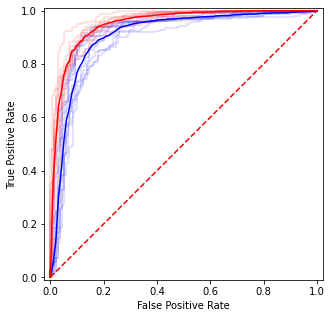

In [155]:
###*** ROC Curve of LR (Comparison between before and after Feature Selection)***
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

X = dataVars_norm
y = data['Tissue_type']

## Binarize the output
y = label_binarize(y, classes=["Cancer","Normal"])
n_classes = y.shape[1]

tprs_b = []
tprs_a =[]

lr_auc_b = np.empty(shape=(10),dtype='float')
lr_auc_a = np.empty(shape=(10),dtype='float')

base_fpr_b = np.linspace(0,1,101)
base_fpr_a = np.linspace(0,1,101)
plt.figure(figsize=(5,5))


rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state =42)
for i, (train_idx, test_idx) in  enumerate(rkf.split(dataVars_norm, data['Tissue_type']),0):
    X_train = X.iloc[train_idx]
    y_train = y[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y[test_idx]
    
    lr_before = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    lr_after = LogisticRegression(solver='liblinear').fit(X_train[fs], y_train)
    
    y_score_before = lr_before.predict_proba(X_test)
    y_score_after = lr_after.predict_proba(X_test[fs])
    
    fpr_b, tpr_b, _b = roc_curve(y_test, y_score_before[:,1])
    fpr_a, tpr_a, _a = roc_curve(y_test, y_score_after[:,1])
    
    lr_probs_b = y_score_before[:,1]
    lr_probs_a = y_score_after[:,1]
    
    
    lr_auc_b[i] = roc_auc_score(y_test, lr_probs_b)
    lr_auc_a[i] = roc_auc_score(y_test, lr_probs_a)
    
    
    plt.plot(fpr_b, tpr_b, 'b', alpha=0.15)
    plt.plot(fpr_a, tpr_a, 'r', alpha= 0.15)
    
    tpr_b = interp(base_fpr_b, fpr_b, tpr_b)
    tpr_a = interp(base_fpr_a, fpr_a, tpr_a)
    tpr_b[0] = 0.0
    tpr_a[0] = 0.0
    tprs_b.append(tpr_b)
    tprs_a.append(tpr_a)
    
tprs_b = np.array(tprs_b)
tprs_a = np.array(tprs_a)

mean_tprs_b = tprs_b.mean(axis=0)
mean_tprs_a = tprs_a.mean(axis=0)
std_b = tprs_b.std(axis=0)
std_a = tprs_a.std(axis=0)

tprs_upper_b = np.minimum(mean_tprs_b + std_b, 1)
tprs_lower_b = mean_tprs_b - std_b

tprs_upper_a = np.minimum(mean_tprs_a + std_a, 1)
tprs_lower_a = mean_tprs_a - std_a

print("LR Before Feature Selection: AUROC = %.3f" % (lr_auc_b.mean()))
print("LR After Feature Selection: AUROC = %.3f" % (lr_auc_a.mean()))

plt.plot(base_fpr_b, mean_tprs_b, 'b', label ='LR before feature selection')
#plt.fill_between(base_fpr_b, tprs_lower_b, tprs_upper_b, color='grey', alpha=0.3)
plt.plot(base_fpr_a, mean_tprs_a, 'r',label ='LR after feature selection (AUROC = %0.3f)')
#plt.fill_between(base_fpr_a, tprs_lower_a, tprs_upper_a, color='green', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('/Users/teeraponsahwangarrom/ROC_Project2_BandA.png', dpi=300)
plt.show()



    ## Build classification model


## LR
#lr_before = LogisticRegression(solver='liblinear')
#lr_before.fit(X_train, y_train)

#lr_after = LogisticRegression(solver='liblinear')
#lr_after.fit(X_train[mf], y_train)
## Prediction probabilities
#r_probs = [0 for _ in range(len(y_test))]

#lr_probs_b = lr_before.predict_proba(X_test)
#lr_probs_a = lr_after.predict_proba(X_test[mf])

# Proabilities for the positive outcome is kept

#lr_probs_b = lr_probs_b[:,1]
#lr_probs_a = lr_probs_a[:,1]
## Computing AUROC and ROC curve values
## Calculate AUROC
## ROC is the receiver operating characteristic AUROC is the area under the ROC curve
#r_auc = roc_auc_score(y_test, r_probs)

#lr_auc_b = roc_auc_score(y_test, lr_probs_b)
#lr_auc_a = roc_auc_score(y_test, lr_probs_a)
## Print AUROC scores
#print("Random (chance) Prediction: AUROC = %.3f" % (r_auc))

#print("LR before feature selection: AUROC = %.3f" % (lr_auc_b))
#print("LR after feature selection: AUROC = %.3f" % (lr_auc_a))

## Claculate ROC curve
#r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

#lr_fpr_b, lr_tpr_b, _b = roc_curve(y_test, lr_probs_b)
#lr_fpr_a, lr_tpr_a, _a = roc_curve(y_test, lr_probs_a)
## Plot ROC curve
#plt.plot(r_fpr, r_tpr, linestyle='--', label ='Random prediction (AUROC = %0.3f)' % r_auc)

#plt.plot(lr_fpr_b, lr_tpr_b, linestyle='solid', label ='LR before feature selection (AUROC = %0.3f)' % lr_auc_b)
#plt.plot(lr_fpr_a, lr_tpr_a, linestyle='solid', label ='LR after feature selection (AUROC = %0.3f)' % lr_auc_a)
## title
#plt.title('ROC Plot')

## Axis labels
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')

## Show legend
#plt.legend()
#plt.show()

In [220]:
dataVars_norm[sdt].to_csv('/Users/teeraponsahwangarrom/Desktop/DataForBP_rkfFinal.csv')

In [387]:
data['Tissue_type'].to_csv('/Users/teeraponsahwangarrom/Desktop/Tissue_type.csv')

In [219]:
sdt = np.array(['794.5690','389.1970','671.4660','700.5820','921.7620','896.7460','157.0520','164.0810'])

In [136]:
## Function for performing logistic regression model
def run_lr(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(solver='liblinear')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))

In [17]:
## Making empty vector for collecting 30 selected features for 100 iterations 
features = np.empty(shape=(100,30),dtype='object')

In [595]:
### Performing recursive feature elimination (RFE) for 100 iterations
## RFE selected 30 important features for each iteration
from sklearn.feature_selection import RFE
n = 0
rskf = RepeatedStratifiedKFold(n_splits=5,n_repeats=20, random_state=42)
for train_idx, test_idx in rskf.split(dataVars_norm, data['Tissue_type']):
    X_train = dataVars_norm.iloc[train_idx]
    y_train = data['Tissue_type'].iloc[train_idx]
    X_test = dataVars_norm.iloc[test_idx]
    y_test = data['Tissue_type'].iloc[test_idx]
    print('Iteration round: ', n)
    print('Accuracy before feature selection')
    run_lr(X_train, X_test, y_train, y_test)
    print()
    sel = RFE(LogisticRegression(solver='liblinear'), n_features_to_select = 30)
    sel.fit(X_train, y_train)
    feature[n] = X_train.columns[sel.get_support()]
    X_train_lr = sel.transform(X_train)
    X_test_lr = sel.transform(X_test)
    n = n+1
    print('Accuracy after feature selection')
    run_lr(X_train_lr, X_test_lr, y_train, y_test)
    print()  

Iteration round:  0
Accuracy before feature selection
Accuracy:  0.8319088319088319

Accuracy after feature selection
Accuracy:  0.7891737891737892

Iteration round:  1
Accuracy before feature selection
Accuracy:  0.8774928774928775

Accuracy after feature selection
Accuracy:  0.8319088319088319

Iteration round:  2
Accuracy before feature selection
Accuracy:  0.8803418803418803

Accuracy after feature selection
Accuracy:  0.8262108262108262

Iteration round:  3
Accuracy before feature selection
Accuracy:  0.8660968660968661

Accuracy after feature selection
Accuracy:  0.8404558404558404

Iteration round:  4
Accuracy before feature selection
Accuracy:  0.8603988603988604

Accuracy after feature selection
Accuracy:  0.8005698005698005

Iteration round:  5
Accuracy before feature selection
Accuracy:  0.8974358974358975

Accuracy after feature selection
Accuracy:  0.8262108262108262

Iteration round:  6
Accuracy before feature selection
Accuracy:  0.8547008547008547

Accuracy after featur

In [ ]:
## To extract the information of RFE's result
features = feature.flatten()
from collections import Counter
counter = Counter(features)
fc_rskf = pd.DataFrame.from_dict(counter, orient='index').reset_index()
fc_rskf = fc_rskf.rename(columns={'index': 'molecular_features', 0:'count'})
fc_rskf.sort_values("count", axis = 0, ascending= False, inplace=True)
fc_rskf

In [598]:
fc_rskf.to_csv('/Users/teeraponsahwangarrom/Desktop/FC_RFE_rskf30_100.csv')

In [221]:
fc = pd.read_csv('/Users/teeraponsahwangarrom/Desktop/FC_RFE_rskf30_100.csv')

In [222]:
feature_RFE = fc.loc[:,['molecular_features']]
mf = feature_RFE.values
mf = mf.flatten()
mf = mf.astype(np.float)
mf = list(map('{:.4f}'.format,mf))
mf = np.array([str(x) for x in mf])
mf

array(['726.5940', '794.5690', '670.5230', '389.1970', '563.5780',
       '239.0880', '167.0340', '750.5440', '700.5820', '291.0870',
       '160.0590', '861.8270', '846.6530', '759.4680', '265.1080',
       '164.0810', '921.7620', '896.7460', '401.2460', '157.0520',
       '199.8650', '790.5420', '250.1200', '762.4950', '316.9140',
       '766.5400', '162.9680', '671.4660', '653.4900', '718.5990',
       '797.7120', '716.5260', '727.5310', '695.4630', '403.2620',
       '437.2690', '501.2580', '698.4860', '297.1210', '294.1470',
       '845.6480', '489.2600', '844.6450', '490.1540', '385.3830',
       '377.2460', '405.2760', '789.5250', '371.1740', '215.0340',
       '776.6210', '788.5560', '616.4700', '361.1630', '333.0960',
       '198.9980', '156.9950', '796.5840', '418.1840', '266.1150',
       '679.5070', '365.3430', '772.5860', '795.6380', '460.2330',
       '797.6570', '463.2300', '723.4990', '798.6620', '672.4690',
       '290.0880', '795.5720', '462.3270', '488.2610', '201.96

In [223]:
mf = mf[:80]

In [519]:
feature_RFE = fc_rskf.loc[:,['molecular_features']]
mf = feature_RFE.values
mf = mf.flatten()
mf

array(['726.5940', '794.5690', '670.5230', '167.0340', '239.0880',
       '389.1970', '700.5820', '291.0870', '750.5440', '563.5780',
       '861.8270', '160.0590', '921.7620', '157.0520', '846.6530',
       '164.0810', '896.7460', '759.4680', '250.1200', '401.2460',
       '265.1080', '671.4660', '653.4900', '316.9140', '199.8650',
       '405.2760', '501.2580', '762.4950', '437.2690', '616.4700',
       '716.5260', '727.5310', '162.9680', '790.5420', '297.1210',
       '403.2620', '418.1840', '718.5990', '371.1740', '766.5400',
       '294.1470', '797.7120', '290.0880', '701.5140', '490.1540',
       '695.4630', '215.0340', '698.4860', '489.2600', '198.9980',
       '385.3830', '377.2460', '333.0960', '789.5250', '844.6450',
       '776.6210', '365.3430', '241.0940', '488.2610', '264.3480',
       '271.2270', '679.5070', '845.6480', '723.4990', '979.7350',
       '788.5560', '461.2330', '545.3270', '201.9670', '460.2330',
       '333.1330', '361.1630', '463.2300', '156.9950', '429.38

In [511]:
dataVars_norm[mf].to_csv('/Users/teeraponsahwangarrom/Desktop/fsRFE_newRSKFData.csv')

In [152]:
#### To calculate sensitivity and specificity 
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))
#models.append(('XGB', XGBClassifier(max_depth =4, n_estimators=150)))

#models.append(('RF', RandomForestClassifier(max_features=6, n_estimators=1000)))
modelList = ['LR']
results = []
names = []
scoring = 'accuracy'

# Store results in a pandas dataframe
numIterations = 10
idx = 80
allAccuracy = pd.DataFrame(index=range(0,numIterations), columns=modelList)
allSensitivity = pd.DataFrame(index=range(0,numIterations), columns=modelList)
allSpecificity = pd.DataFrame(index=range(0,numIterations), columns=modelList)

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats = 2, random_state=42)

for n,(train_idx, test_idx) in enumerate(rskf.split(dataVars_norm, data['Tissue_type']),0):
    
    for name, model in models:
        
        
    
        X_train = dataVars_norm.iloc[train_idx]
        y_train = data['Tissue_type'].iloc[train_idx]
        X_test = dataVars_norm.iloc[test_idx]
        y_test = data['Tissue_type'].iloc[test_idx]
        
        #feature_RFE = fc_rkf.loc[:,['molecular_features']]
        
        #mf = feature_RFE[:idx].values
        #mf = mf.flatten()
        fs = mf[:idx]
        
        
    # Cross validated model generation
        model.fit(X_train[fs], y_train)
        y_pred = model.predict(X_test[fs])
        
        
        cm = confusion_matrix(y_test, y_pred)
        total = sum(sum(cm))
        print('Round: ', n, name)
        Accuracy = (cm[0,0]+cm[1,1])/total
        print('Accuracy: ', Accuracy*100)
        
        Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
        print('Sensitivity: ', Sensitivity*100)
        Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
        print('Specificity: ', Specificity*100)
        
        
        allAccuracy.iloc[n][name] = Accuracy*100
        allSensitivity.iloc[n][name] = Sensitivity*100
        allSpecificity.iloc[n][name] = Specificity*100
        

Round:  0 LR
Accuracy:  86.6096866096866
Sensitivity:  82.85714285714286
Specificity:  89.0995260663507
Round:  1 LR
Accuracy:  88.6039886039886
Sensitivity:  82.14285714285714
Specificity:  92.89099526066352
Round:  2 LR
Accuracy:  90.5982905982906
Sensitivity:  87.76978417266187
Specificity:  92.45283018867924
Round:  3 LR
Accuracy:  92.5925925925926
Sensitivity:  89.20863309352518
Specificity:  94.81132075471697
Round:  4 LR
Accuracy:  88.88888888888889
Sensitivity:  83.45323741007195
Specificity:  92.45283018867924
Round:  5 LR
Accuracy:  90.5982905982906
Sensitivity:  88.57142857142857
Specificity:  91.9431279620853
Round:  6 LR
Accuracy:  89.45868945868945
Sensitivity:  83.57142857142857
Specificity:  93.36492890995261
Round:  7 LR
Accuracy:  89.45868945868945
Sensitivity:  83.45323741007195
Specificity:  93.39622641509435
Round:  8 LR
Accuracy:  88.6039886039886
Sensitivity:  87.05035971223022
Specificity:  89.62264150943396
Round:  9 LR
Accuracy:  88.6039886039886
Sensitivity: 

In [153]:
allAccuracy.mean()

LR    89.401709
dtype: float64

In [143]:
allAccuracy.std()

LR    1.197109
dtype: float64

In [144]:
allSensitivity.mean()

LR    84.579137
dtype: float64

In [145]:
allSpecificity.mean()

LR    92.153715
dtype: float64

In [102]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_idx, test_idx in skf.split(dataVars_norm, data['Tissue_type']):
    train_X, test_X = dataVars_norm.iloc[train_idx], dataVars_norm.iloc[test_idx]
    train_y, test_y = data['Tissue'].iloc[train_idx], data['Tissue'].iloc[test_idx]
    
    train_Breast, train_Colorectal, train_Gynae = len(train_y[train_y=="Breast"]), len(train_y[train_y=="Colorectal"]), len(train_y[train_y=="Gynae"])
    test_Breast, test_Colorectal, test_Gynae = len(test_y[test_y=="Breast"]), len(test_y[test_y=="Colorectal"]), len(test_y[test_y=="Gynae"])
    print('Train: Breast = %d, Colorectal = %d, Gynae = %d' % (train_Breast, train_Colorectal, train_Gynae))
    
    print('Test: Breast = %d, Colorectal = %d, Gynae = %d' % (test_Breast, test_Colorectal, test_Gynae))
    

Train: Breast = 1102, Colorectal = 240, Gynae = 62
Test: Breast = 265, Colorectal = 64, Gynae = 22
Train: Breast = 1089, Colorectal = 247, Gynae = 68
Test: Breast = 278, Colorectal = 57, Gynae = 16
Train: Breast = 1083, Colorectal = 252, Gynae = 69
Test: Breast = 284, Colorectal = 52, Gynae = 15
Train: Breast = 1099, Colorectal = 239, Gynae = 66
Test: Breast = 268, Colorectal = 65, Gynae = 18
Train: Breast = 1095, Colorectal = 238, Gynae = 71
Test: Breast = 272, Colorectal = 66, Gynae = 13


In [203]:
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
for train_idx, test_idx in rkf.split(dataVars_norm, data['Tissue_type']):
    train_X, test_X = dataVars_norm.iloc[train_idx], dataVars_norm.iloc[test_idx]
    train_y, test_y = data['Tissue'].iloc[train_idx], data['Tissue'].iloc[test_idx]
    
    train_Breast, train_Colorectal, train_Gynae = len(train_y[train_y=="Breast"]), len(train_y[train_y=="Colorectal"]), len(train_y[train_y=="Gynae"])
    test_Breast, test_Colorectal, test_Gynae = len(test_y[test_y=="Breast"]), len(test_y[test_y=="Colorectal"]), len(test_y[test_y=="Gynae"])
    print('Train: Breast = %d, Colorectal = %d, Gynae = %d' % (train_Breast, train_Colorectal, train_Gynae))
    
    print('Test: Breast = %d, Colorectal = %d, Gynae = %d' % (test_Breast, test_Colorectal, test_Gynae))
    

Train: Breast = 1085, Colorectal = 260, Gynae = 59
Test: Breast = 282, Colorectal = 44, Gynae = 25
Train: Breast = 1096, Colorectal = 238, Gynae = 70
Test: Breast = 271, Colorectal = 66, Gynae = 14
Train: Breast = 1090, Colorectal = 244, Gynae = 70
Test: Breast = 277, Colorectal = 60, Gynae = 14
Train: Breast = 1082, Colorectal = 253, Gynae = 69
Test: Breast = 285, Colorectal = 51, Gynae = 15
Train: Breast = 1115, Colorectal = 221, Gynae = 68
Test: Breast = 252, Colorectal = 83, Gynae = 16
Train: Breast = 1091, Colorectal = 242, Gynae = 71
Test: Breast = 276, Colorectal = 62, Gynae = 13
Train: Breast = 1090, Colorectal = 243, Gynae = 71
Test: Breast = 277, Colorectal = 61, Gynae = 13
Train: Breast = 1088, Colorectal = 249, Gynae = 67
Test: Breast = 279, Colorectal = 55, Gynae = 17
Train: Breast = 1113, Colorectal = 228, Gynae = 63
Test: Breast = 254, Colorectal = 76, Gynae = 21
Train: Breast = 1086, Colorectal = 254, Gynae = 64
Test: Breast = 281, Colorectal = 50, Gynae = 20


In [135]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5,n_repeats= 5, random_state=42)
for train_idx, test_idx in rkf.split(dataVars_norm, data['Tissue_type']):
    train_X, test_X = dataVars_norm.iloc[train_idx], dataVars_norm.iloc[test_idx]
    train_y, test_y = data['Tissue'].iloc[train_idx], data['Tissue'].iloc[test_idx]
    
    train_Breast, train_Colorectal, train_Gynae = len(train_y[train_y=="Breast"]), len(train_y[train_y=="Colorectal"]), len(train_y[train_y=="Gynae"])
    test_Breast, test_Colorectal, test_Gynae = len(test_y[test_y=="Breast"]), len(test_y[test_y=="Colorectal"]), len(test_y[test_y=="Gynae"])
    print('Train: Breast = %d, Colorectal = %d, Gynae = %d' % (train_Breast, train_Colorectal, train_Gynae))
    
    print('Test: Breast = %d, Colorectal = %d, Gynae = %d' % (test_Breast, test_Colorectal, test_Gynae))
    

Train: Breast = 1085, Colorectal = 260, Gynae = 59
Test: Breast = 282, Colorectal = 44, Gynae = 25
Train: Breast = 1096, Colorectal = 238, Gynae = 70
Test: Breast = 271, Colorectal = 66, Gynae = 14
Train: Breast = 1090, Colorectal = 244, Gynae = 70
Test: Breast = 277, Colorectal = 60, Gynae = 14
Train: Breast = 1082, Colorectal = 253, Gynae = 69
Test: Breast = 285, Colorectal = 51, Gynae = 15
Train: Breast = 1115, Colorectal = 221, Gynae = 68
Test: Breast = 252, Colorectal = 83, Gynae = 16
Train: Breast = 1091, Colorectal = 242, Gynae = 71
Test: Breast = 276, Colorectal = 62, Gynae = 13
Train: Breast = 1090, Colorectal = 243, Gynae = 71
Test: Breast = 277, Colorectal = 61, Gynae = 13
Train: Breast = 1088, Colorectal = 249, Gynae = 67
Test: Breast = 279, Colorectal = 55, Gynae = 17
Train: Breast = 1113, Colorectal = 228, Gynae = 63
Test: Breast = 254, Colorectal = 76, Gynae = 21
Train: Breast = 1086, Colorectal = 254, Gynae = 64
Test: Breast = 281, Colorectal = 50, Gynae = 20
Train: Bre

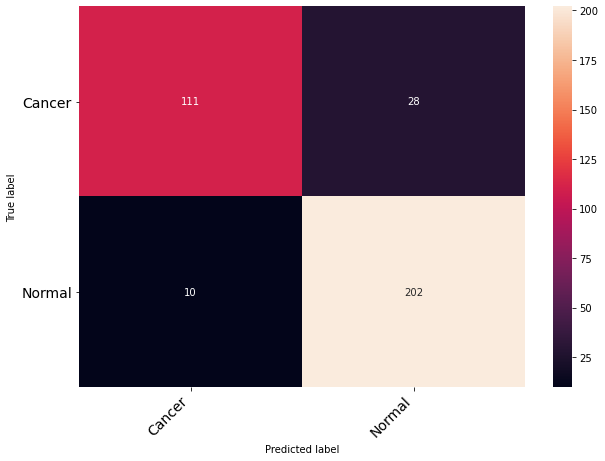

In [97]:
print_confusion_matix(cm, class_names=['Cancer','Normal'], figsize = (10,7), fontsize=14)